##Copy data from Google Drive to local storage

The data for the project is hosted on Google Drive. Reading files from Google Drive is slow, so we copy the dataset to local storage on the system where the python interpreter is running to accelerate data access.

In [1]:
from google.colab import drive
import os

# mount google drive containing data, mil library
drive.mount("/content/drive")

# copy data to local folder for fast i/o
drive_path = "/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/segmentation_project/segmentation_project_data.zip"
local_path = "./segmentation_project/segmentation_project_data.zip" # root local destination for unzipped data in ./train, ./validation
if not os.path.exists(os.path.split(local_path)[0]):
  !mkdir {os.path.split(local_path)[0]}
if not os.path.isdir("./segmentation_project/segmentation_project_data"):
  !cp {drive_path} {local_path}
  !unzip {local_path} -d {os.path.split(local_path)[0]}
  !rm {local_path}

Mounted at /content/drive
Archive:  ./segmentation_project/segmentation_project_data.zip
  inflating: ./segmentation_project/.DS_Store  
   creating: ./segmentation_project/test/
  inflating: ./segmentation_project/test/00791_t1.png  
  inflating: ./segmentation_project/test/01011_t1.png  
  inflating: ./segmentation_project/test/01193_t2.png  
  inflating: ./segmentation_project/test/00274_mask.png  
  inflating: ./segmentation_project/test/01416_t2.png  
  inflating: ./segmentation_project/test/00150_t2.png  
  inflating: ./segmentation_project/test/00601_t2.png  
  inflating: ./segmentation_project/test/01081_t2.png  
  inflating: ./segmentation_project/test/01598_t1.png  
  inflating: ./segmentation_project/test/01498_t1.png  
  inflating: ./segmentation_project/test/00033_t2.png  
  inflating: ./segmentation_project/test/01160_t1.png  
  inflating: ./segmentation_project/test/00457_t1.png  
  inflating: ./segmentation_project/test/01083_mask.png  
  inflating: ./segmentation_proje

## Create training, validation, test sets

The training, validation, and test folders contain sets of T1, T2, mask images for each subject. Create separate dataset objects from these folders.

The dataset objects emit (x,y) tuples where x is a 240x240x2 array containing the T1 and T2 images in that order, and y is a 240x240x3 array containing binary images for the background, T1 contrast enhancing, and T2 abnormality masks in that order.


In [2]:
from json import load
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data Augmentation Function

def dataset(mode, folder, extension=".png"):
  # Added "mode", which indicates the dataset category of train, validation, test
  # Skip TTA if mode[0] = 'Train' or 'Validation'
  # Apply data augmentation if mode[0] = 'Test', and in this case, mode[1] indicates augmentation version

    """Create a dataset object from a folder containing masks, t1, and t2 images.

    The dataset is an iterator that emits (x,y) tuples with the form:

    x - an M x N x 2 array containing the t1 and t2 images in channels 1,2 respectively
    y - an M x N x 3 array containing the masks for background, contrast enhancement,
        and t2 abnormality in channels 1, 2, and 3 respectively.
    """
    # # Store Test subject ID for future use
    # if mode[0] == 'Test':
    #   global subjects
    # else:
    #   del globals()["subjects"]

    # generate 3-tuples of t1, t2, mask for each subject
    files = [f for f in os.listdir(folder) if os.path.splitext(f)[1] == extension]
    subjects = set([f.split("_")[0] for f in files])
    triplets = []
    for s in subjects:
        if (os.path.isfile(os.path.join(folder, f"{s}_t1{extension}"))
            and os.path.isfile(os.path.join(folder, f"{s}_t2{extension}"))
            and os.path.isfile(os.path.join(folder, f"{s}_mask{extension}"))
        ):
            triplets.append(
                (os.path.join(folder, f"{s}_t1{extension}"),
                 os.path.join(folder, f"{s}_t2{extension}"),
                 os.path.join(folder, f"{s}_mask{extension}"))
            )

    # create a dataset - map read, decode, and stack operation to create a
    # 2-channel input x (t1, t2) and a 3-channel label y (0, t1+, t2+)
    def read_decode(x):
        return tf.io.decode_image(tf.io.read_file(x))
    def mask(x):
        return tf.cast(tf.concat([tf.equal(x,0), tf.equal(x,1), tf.equal(x,2)], axis=2), tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(triplets)
    ds = ds.map(lambda x: (read_decode(x[0]), read_decode(x[1]), read_decode(x[2])))
    ds = ds.map(lambda x,y,z: (tf.concat([x,y],axis=2), mask(z)))
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    ds = ds.map(lambda x,y: (tf.ensure_shape(x, [240, 240, 2]), tf.ensure_shape(y, [240, 240, 3])))

    # If TEST dataset, apply data augmentation (TTA)
    if mode[0] == 'Test':
      print("Processing test dataset for TTA: ", end="")
      #ds = ds.map(lambda x,y: (mode[1].random_transform(x), y)) # data augmentation at "test-time"
      if mode[1] == 'original':
        print("No modifying image here...")
        "Nothing to do here"
      if mode[1] == 'rot90':
        print("Rotating for 90 degrees...")
        ds = ds.map(lambda x,y: (tf.image.rot90(x), tf.image.rot90(y)))
      if mode[1] == 'rot180':
        print("Rotating for 180 degrees...")
        ds = ds.map(lambda x,y: (tf.image.rot90(x, 2), tf.image.rot90(y, 2)))
      if mode[1] == 'rot270':
        print("Rotating for 270 degrees...")
        ds = ds.map(lambda x,y: (tf.image.rot90(x, 3), tf.image.rot90(y, 3)))
      if mode[1] == 'fliph':
        print("Flipping vertically...")
        ds = ds.map(lambda x,y: (tf.image.flip_up_down(x), tf.image.flip_up_down(y)))
      if mode[1] == 'flipw':
        print("Flipping horizontally...")
        ds = ds.map(lambda x,y: (tf.image.flip_left_right(x), tf.image.flip_left_right(y)))

    return ds


## Class weights and normalization data

The base folder has JSON files containing the total pixel counts for each class (class_weights.json) and mean and variance statistics for the images (normalization.json).

Since the classes are highly imbalanced, we use class weights to encourage the optimization to focus more on the less common classes of T1 contrast enhancement and T2 abnormality. These weights are calculated as the inverse prevalance for each class.

The normalization contains mean and variance statistics for the T1 and T2 channels of the input. These are used to shift and scale the network inputs.

In [3]:
def load_class_weights(file):
    """Load class counts and calculate class weights."""

    with open(file) as f:
        class_weights = load(f)
    class_weights = np.array([v for v in class_weights.values()])
    class_weights = np.sum(class_weights) / class_weights

    return class_weights


def load_normalization(file):
    """Load normalization statistics."""

    with open(file) as f:
        statistics = load(f)
    mu = [statistics["t1_mu"], statistics["t2_mu"]]
    sigma = [statistics["t1_sigma"], statistics["t2_sigma"]]

    return mu, sigma

## Create a U-Net network (Step 1 / Step 2)

The network you will implement is similar to U-Net where the upconvolutions have been replaced with simple upsampling layers (tf.keras.layers.UpSampling2D or torch.nn.Upsample in PyTorch).


In [4]:
from tensorflow.keras import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import (
    concatenate, Conv2D, Dense, Input, Lambda, MaxPooling2D, UpSampling2D
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import IoU
from tensorflow import constant

# define a block of convolutions for each step in the U-net
def conv_block(x, filters, name, layers=2, kernel_size=3, activation="relu"):
    for layer in range(layers):
        x = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            activation=activation,
            padding="same",
            name=f"{name}_{layer}"
            )(x)
    return x

# input channel - we feed in a 2-channel image containing t1, t2 channels
xi = Input((240, 240, 2), dtype=tf.float32)

# normalize on GPU for additional speed
mu, sigma = load_normalization("./segmentation_project/normalization.json")
mu = constant([[[list(mu)]]], dtype=tf.float32)
sigma = constant([[[list(sigma)]]], dtype=tf.float32)
xn = Lambda(lambda x: (x-mu)/sigma)(xi)

################################################################################
# add your model layers here - terminating in "output" #########################

### TRAINABLE UP-CONVOLUTIONS LAYER
from tensorflow.keras.layers import Conv2DTranspose, Layer
class UpConv2D(Layer):
  def __init__(self, filters, kernel_size, strides, **kwargs):
    super().__init__(**kwargs)
    self._Conv2DT = Conv2DTranspose(filters, kernel_size, strides)

  def call(self, x, training): # Input feature = x
    return self._Conv2DT(x)

### OPTION! 1. U-Net with Up-Sampling (U-Net Like); 2. U-Net with UpConv (U-Net) ###
print("1. U-Net with Up-Sampling   (U-Net Like)")
print("2. U-Net with Up-Convlution (Original U-Net)")
ModelOpt = int(input("Choose a option: "))
if not (ModelOpt==1 or ModelOpt==2):
  print("Choose a correct option... Interpreted as option 1.")

blocked1 = conv_block(xn, 64, "1", 2, 3, "relu") # conv_block(x, filters, name, layers=2, kernel_size=3, activation="relu"):
print("shape blocked1: " + str(blocked1[0].shape))
maxpooled1 = MaxPooling2D()(blocked1)
print("shape maxpooled1: " + str(maxpooled1[0].shape))
blocked2 = conv_block(maxpooled1, 128, "2", 2, 3, "relu")
print("shape blocked2: " + str(blocked2[0].shape))
maxpooled2 = MaxPooling2D()(blocked2)
print("shape maxpooled2: " + str(maxpooled2[0].shape))
blocked3 = conv_block(maxpooled2, 256, "3", 2, 3, "relu")
print("shape blocked3: " + str(blocked3[0].shape))

if ModelOpt == 2:
  upsampled1 = UpConv2D(blocked3[0].shape[-1], 2, 2)(blocked3) # filters (here keep same), kernel_size, strides
  print("shape upconved1: " + str(upsampled1[0].shape))
else:
  upsampled1 = UpSampling2D(size=(2, 2))(blocked3)
  print("shape upsampled1: " + str(upsampled1[0].shape))

concat1 = concatenate([blocked2, upsampled1], axis=-1)
print("shape concat1: " + str(concat1[0].shape))
blocked4 = conv_block(concat1, 128, "4", 2, 3, "relu")
print("shape blocked4: " + str(blocked4[0].shape))

if ModelOpt == 2:
  upsampled2 = UpConv2D(blocked4[0].shape[-1], 2, 2)(blocked4) # filter = keep same
  print("shape upconved2: " + str(upsampled2[0].shape))
else:
  upsampled2 = UpSampling2D(size=(2, 2))(blocked4)
  print("shape upsampled2: " + str(upsampled2[0].shape))

concat2 = concatenate([blocked1, upsampled2], axis=-1)
print("shape concat2: " + str(concat2[0].shape))
blocked5 = conv_block(concat2, 64, "5", 2, 3, "relu")
print("shape blocked5: " + str(blocked5[0].shape))
output = Conv2D(filters=3,kernel_size=(3, 3),activation="softmax",padding="same")(blocked5)
print("shape output: " + str(output[0].shape))
################################################################################

# load class weights
class_weights = load_class_weights("./segmentation_project/class_weights.json")

# create and compile a model
model = Model(inputs=[xi], outputs=[output])
model.compile(
    loss=CategoricalCrossentropy(),
    loss_weights=list(class_weights),
    metrics=[
        IoU(3, target_class_ids=[1], sparse_y_true=False, sparse_y_pred=False, name="t1_iou"),
        IoU(3, target_class_ids=[2], sparse_y_true=False, sparse_y_pred=False, name="t2_iou")
    ]
)

1. U-Net with Up-Sampling   (U-Net Like)
2. U-Net with Up-Convlution (Original U-Net)
Choose a option: 2
shape blocked1: (240, 240, 64)
shape maxpooled1: (120, 120, 64)
shape blocked2: (120, 120, 128)
shape maxpooled2: (60, 60, 128)
shape blocked3: (60, 60, 256)
shape upconved1: (120, 120, 256)
shape concat1: (120, 120, 384)
shape blocked4: (120, 120, 128)
shape upconved2: (240, 240, 128)
shape concat2: (240, 240, 192)
shape blocked5: (240, 240, 64)
shape output: (240, 240, 3)


## [Step 1] Train the model (Baseline Record)

In [6]:
# generate train, validation datasets and fit
train = dataset(['Train',''], "./segmentation_project/train/").batch(4).prefetch(1).cache()
validation = dataset(['Validation',''], "./segmentation_project/validation/").batch(4).prefetch(1).cache()
model.fit(train, epochs=30, validation_data=validation)

Epoch 1/30
250/250 [==============================] - 53s 144ms/step - loss: 0.2321 - t1_iou: 0.0000e+00 - t2_iou: 0.2450 - val_loss: 0.0907 - val_t1_iou: 0.0000e+00 - val_t2_iou: 0.3118
Epoch 2/30
250/250 [==============================] - 34s 138ms/step - loss: 0.0898 - t1_iou: 0.0415 - t2_iou: 0.3482 - val_loss: 0.0780 - val_t1_iou: 0.0561 - val_t2_iou: 0.4159
Epoch 3/30
250/250 [==============================] - 34s 136ms/step - loss: 0.0760 - t1_iou: 0.2133 - t2_iou: 0.4283 - val_loss: 0.0685 - val_t1_iou: 0.1382 - val_t2_iou: 0.4996
Epoch 4/30
250/250 [==============================] - 35s 139ms/step - loss: 0.0658 - t1_iou: 0.3194 - t2_iou: 0.4907 - val_loss: 0.0641 - val_t1_iou: 0.1342 - val_t2_iou: 0.5807
Epoch 5/30
250/250 [==============================] - 34s 135ms/step - loss: 0.0592 - t1_iou: 0.3796 - t2_iou: 0.5257 - val_loss: 0.0557 - val_t1_iou: 0.2856 - val_t2_iou: 0.6086
Epoch 6/30
250/250 [==============================] - 35s 139ms/step - loss: 0.0526 - t1_iou: 0.4

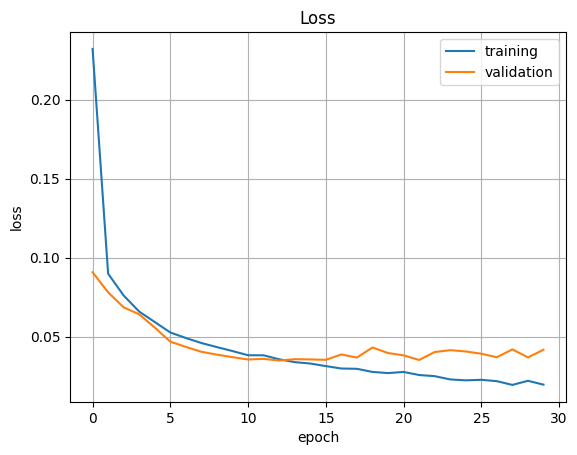

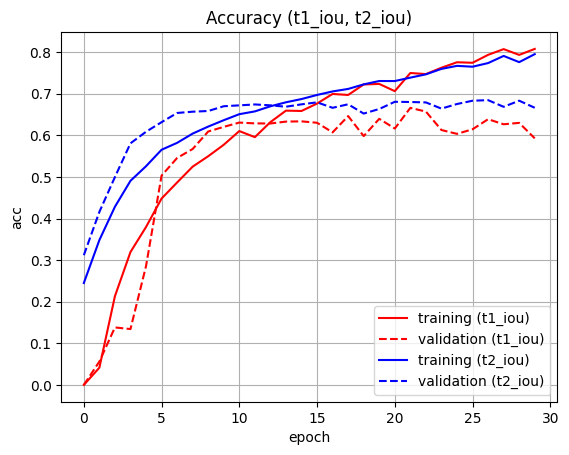

In [7]:
# curves
print(model.history)

import matplotlib.pyplot as plt
def visualize_loss(session):
    plt.figure()
    plt.plot(session.history["loss"])
    plt.plot(session.history["val_loss"])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend(["training", "validation"])
    plt.title('Loss')
visualize_loss(model.history)

def visualize_iou(session):
    plt.figure()
    plt.plot(session.history["t1_iou"], color='red')
    plt.plot(session.history["val_t1_iou"], linestyle = "--", color='red') # linewidth = 0.2,
    plt.plot(session.history["t2_iou"], color='blue')
    plt.plot(session.history["val_t2_iou"], linestyle = "--", color='blue')
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.grid()
    plt.legend(["training (t1_iou)", "validation (t1_iou)", "training (t2_iou)", "validation (t2_iou)"])
    plt.title('Accuracy (t1_iou, t2_iou)')
visualize_iou(model.history)

## [Step 1] Evaluate on testing data (Baseline Record)


In [14]:
test = dataset(["Test", ""], "./segmentation_project/test/").batch(4).prefetch(1)
model.evaluate(test)

32/32 [==============================] - 2s 46ms/step - loss: 0.0485 - t1_iou: 0.5191 - t2_iou: 0.6307


[0.04848514124751091, 0.5190766453742981, 0.6307026743888855]

## [Step 1] Display model blocks (Baseline Record)

In [9]:
# my model has 1884227 parameters (100% are trainable)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 2)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 240, 240, 2)          0         ['input_1[0][0]']             
                                                                                                  
 1_0 (Conv2D)                (None, 240, 240, 64)         1216      ['lambda[0][0]']              
                                                                                                  
 1_1 (Conv2D)                (None, 240, 240, 64)         36928     ['1_0[0][0]']                 
                                                                                              

## [Step 1] Visualize model output

Superimpose the segmentation result on the input images and compare to the ground truth.

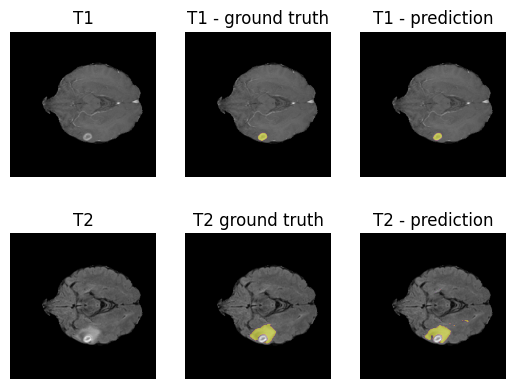

In [17]:
import matplotlib.pyplot as plt

def visualize(x, y, y_hat):
    """Overlay prediction and ground truth on images."""

    # overlay colormap
    colormap = "plasma"

    # T1 raw
    ax = plt.subplot(2,3,1)
    plt.imshow(np.array(x)[:,:,0].astype(np.uint8), "gray")
    ax.set_title("T1")
    plt.axis("off")

    # T2 raw
    ax = plt.subplot(2,3,4)
    plt.imshow(np.array(x)[:,:,1].astype(np.uint8), "gray")
    ax.set_title("T2")
    plt.axis("off")

    # T1 ground truth
    ax = plt.subplot(2,3,2)
    plt.imshow(np.array(x)[:,:,0].astype(np.uint8), "gray")
    mask = np.array(y)[:,:,1]/np.max(np.array(y)[:,:,1])
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T1 - ground truth")
    plt.axis("off")

    # T2 ground truth
    ax = plt.subplot(2,3,5)
    plt.imshow(np.array(x)[:,:,1].astype(np.uint8), "gray")
    mask = np.array(y)[:,:,2]/np.max(np.array(y)[:,:,2])
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T2 ground truth")
    plt.axis("off")

    # T1 prediction
    ax = plt.subplot(2,3,3)
    plt.imshow(np.array(x)[:,:,0].astype(np.uint8), "gray")
    mask = np.argmax(y_hat, axis=-1) == 1
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T1 - prediction")
    plt.axis("off")

    # T2 prediction
    ax = plt.subplot(2,3,6)
    plt.imshow(np.array(x)[:,:,1].astype(np.uint8), "gray")
    mask = np.argmax(y_hat, axis=-1) == 2
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T2 - prediction")
    plt.axis("off")

# show one result
x, y = list(train.unbatch().take(1))[0]
y_hat = model(np.array([x]))[0] # add batch dim to input, remove batch dim from output
visualize(x, y, y_hat)

##[Step 2] Evaluate with Test-time Augmentation (TTA)

In [47]:
# Test data augmentation Pre-processing (Making 6 versions including original one)
  # FIVE VERSIONS; 90 rtt, 180 rtt, 270 rtt, horizontal flip, vertical flip
  # Since this model is pixel-size classification, any in-revertable image processing are not allowed for TTA.
  # Define test dataset with image processing for each version (order should be same, unless any other option randomize the dataset order)

# 0. Original
TTA0 = dataset(['Test', 'original'], "./segmentation_project/test/").batch(4).prefetch(1)
Pred0 = model.predict(TTA0)

# Fetch True Label as tensor
LabelData = []  # store true labels
for x, y in TTA0: # x = data, y = label (mask)) # iterate over the dataset
  LabelData.append(y) # Adding True labels from original dataset
#LabelData = np.argmax(tf.concat([i for i in LabelData], axis=0), axis=-1)
LabelData = tf.concat([i for i in LabelData], axis=0)
print(" - Original label shape:" + str(LabelData.shape))

# 1. 90 degree rotation
TTA1 = dataset(['Test', 'rot90'], "./segmentation_project/test/").batch(4).prefetch(1)
Pred1 = model.predict(TTA1)
Pred1 = tf.image.rot90(Pred1, 3) # Revert

# 2. 180 degree rotation
TTA2 = dataset(['Test', 'rot180'], "./segmentation_project/test/").batch(4).prefetch(1)
Pred2 = model.predict(TTA2)
Pred2 = tf.image.rot90(Pred2, 2) # Revert

# 3. 270 degree rotation
TTA3 = dataset(['Test', 'rot270'], "./segmentation_project/test/").batch(4).prefetch(1)
Pred3 = model.predict(TTA3)
Pred3 = tf.image.rot90(Pred3, 1) # Revert

# 4. Vertical flip
TTA4 = dataset(['Test', 'fliph'], "./segmentation_project/test/").batch(4).prefetch(1) # (fliph = fliphorizontal!!!!!!!)
Pred4 = model.predict(TTA4)
Pred4 = tf.image.flip_up_down(Pred4) # Revert

# 5. Horizontal flip
TTA5 = dataset(['Test', 'flipw'], "./segmentation_project/test/").batch(4).prefetch(1)
Pred5 = model.predict(TTA5)
Pred5 = tf.image.flip_left_right(Pred5) # Revert

# Making 5 versions to one variable
Pred_Concat = np.stack([Pred0, Pred1, Pred2, Pred3, Pred4, Pred5])

# Average each version's prediction; along axis=0
print("Taking average from all prediction...")
TTA_Avg = np.average(Pred_Concat, axis=0)

Baseline_Avg = Pred0 # IF only used original data...? MUST BE == Evaluation Acc
print(" - Averaged prediction label shape: " + str(TTA_Avg.shape))

# Find maximum (channel dimension will be reducted and every element will be whether 0, 1, 2 )
# # print(" -> [Find Maximum Value] -> ", end="")
# # TTA_ArgMax = np.argmax(TTA_Avg, axis=-1)
# print(" - Shape: " + str(TTA_ArgMax.shape))

# very primitive; need to find efficient one
print("Converting predicted label...") # manually doing evaluation; maximum probability position along channels = 1, others = 0
for N in range(TTA_Avg.shape[0]):
    for H in range(TTA_Avg.shape[1]):
        for W in range(TTA_Avg.shape[2]):
            # TTA
            MaxIndex = np.argmax(TTA_Avg[N, H, W, :])
            TTA_Avg[N, H, W, :] = 0
            TTA_Avg[N, H, W, MaxIndex] = 1

            # Baseline
            MaxIndex_Base = np.argmax(Baseline_Avg[N, H, W, :])
            Baseline_Avg[N, H, W, :] = 0
            Baseline_Avg[N, H, W, MaxIndex_Base] = 1

# Initialize IoU for each class
IOU_Predict = [IoU(3, target_class_ids=[i], sparse_y_true=False, sparse_y_pred=False) for i in range(3)]
IOU_Predict_Baseline = [IoU(3, target_class_ids=[i], sparse_y_true=False, sparse_y_pred=False) for i in range(3)]
for i in [1,2]:
    IOU_Predict[i].update_state(LabelData, TTA_Avg)
    IOU_Predict_Baseline[i].update_state(LabelData, Baseline_Avg)
    print(f'T{i} IoU (TTA) :', '{:.4f}'.format(IOU_Predict[i].result().numpy()), end=", ")
    print(f'T{i} IoU (Original) :', '{:.4f}'.format(IOU_Predict_Baseline[i].result().numpy()))


Processing test dataset for TTA: No modifying image here...
32/32 [==============================] - 1s 42ms/step
 - Original label shape:(125, 240, 240, 3)
Processing test dataset for TTA: Rotating for 90 degrees...
32/32 [==============================] - 2s 44ms/step
Processing test dataset for TTA: Rotating for 180 degrees...
32/32 [==============================] - 2s 46ms/step
Processing test dataset for TTA: Rotating for 270 degrees...
32/32 [==============================] - 1s 41ms/step
Processing test dataset for TTA: Flipping vertically...
32/32 [==============================] - 1s 43ms/step
Processing test dataset for TTA: Flipping horizontally...
32/32 [==============================] - 2s 44ms/step
Taking average from all prediction...
 - Averaged prediction label shape: (125, 240, 240, 3)
Converting predicted label...
T1 IoU (TTA) : 0.5278, T1 IoU (Original) : 0.5191
T2 IoU (TTA) : 0.6631, T2 IoU (Original) : 0.6307


0 0 1 2 3 4 5 6 7 8 9 

0 

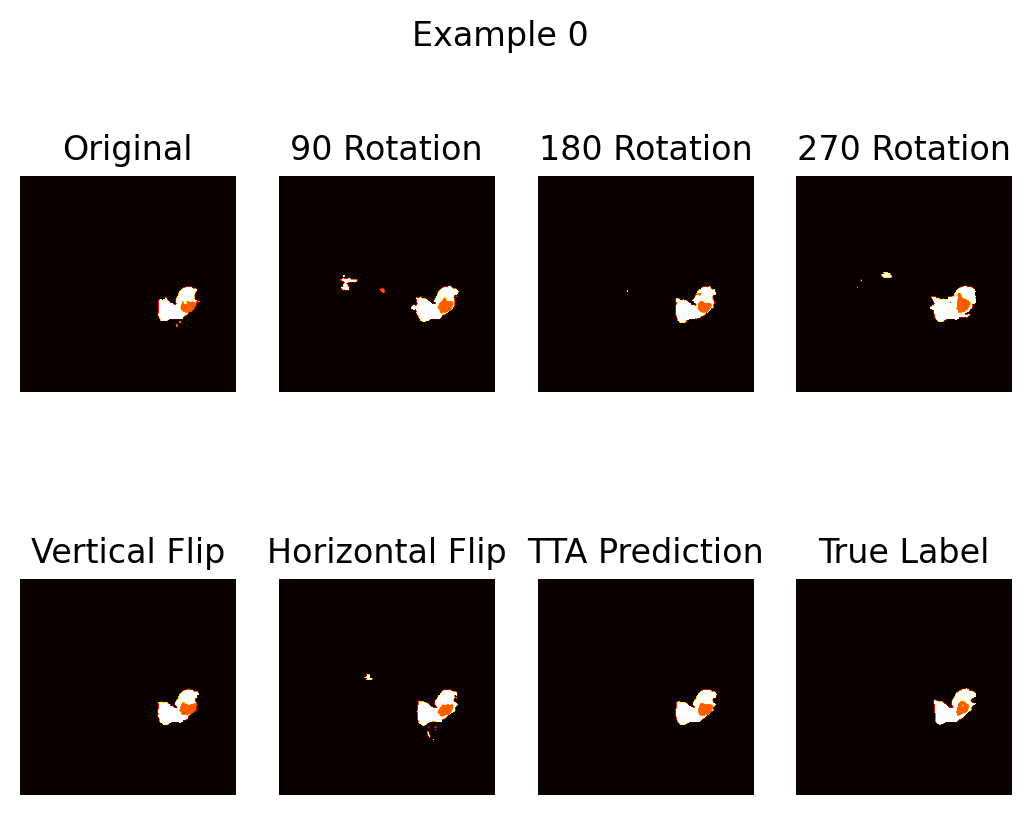

In [12]:
# Quality Checker for TTA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# [Version, N, H, W]
all_data = [np.argmax(Pred0, axis=-1), np.argmax(Pred1, axis=-1),
            np.argmax(Pred2, axis=-1), np.argmax(Pred3, axis=-1),
            np.argmax(Pred4, axis=-1), np.argmax(Pred5, axis=-1),
            np.argmax(TTA_Avg, axis=-1), np.argmax(LabelData, axis=-1)]
all_data = np.stack(all_data, axis=-1)
all_data = all_data[0:10,...] # fetch only some

Title = [["Original", "90 Rotation", "180 Rotation", "270 Rotation"],
         ["Vertical Flip", "Horizontal Flip", "TTA Prediction", "True Label"]]

fig, axes = plt.subplots(2, 4, dpi=200)
def my_func(j): # j = Animation frames
  print(str(j), end=" ")
  ii=0
  for i in range(2):
    for k in range(4):
      axes[i][k].imshow(all_data[j,:,:,ii], cmap='hot') # i = version
      axes[i][k].set_title(Title[i][k])
      axes[i][k].axis("off")
      ii=ii+1

    fig.suptitle("Example " + str(j)) # Subject ID
    plt.show

TTA_Animation = FuncAnimation(fig = fig, func = my_func, frames = all_data.shape[0], interval = 1000, blit = False)
HTML(TTA_Animation.to_html5_video())

## [Step 2 (Additional)] Train the model (U-Net (Trainable Up-Conv) Record)

In [5]:
# generate train, validation datasets and fit
train = dataset(['Train',''], "./segmentation_project/train/").batch(4).prefetch(1).cache()
validation = dataset(['Validation',''], "./segmentation_project/validation/").batch(4).prefetch(1).cache()
model.fit(train, epochs=30, validation_data=validation)

Epoch 1/30
250/250 [==============================] - 62s 175ms/step - loss: 0.1122 - t1_iou: 7.7259e-04 - t2_iou: 0.2582 - val_loss: 0.0921 - val_t1_iou: 0.0000e+00 - val_t2_iou: 0.4164
Epoch 2/30
250/250 [==============================] - 39s 154ms/step - loss: 0.0913 - t1_iou: 0.0618 - t2_iou: 0.3145 - val_loss: 0.0914 - val_t1_iou: 0.0054 - val_t2_iou: 0.4205
Epoch 3/30
250/250 [==============================] - 39s 155ms/step - loss: 0.0847 - t1_iou: 0.1779 - t2_iou: 0.3415 - val_loss: 0.0828 - val_t1_iou: 0.0905 - val_t2_iou: 0.4457
Epoch 4/30
250/250 [==============================] - 39s 155ms/step - loss: 0.0780 - t1_iou: 0.2246 - t2_iou: 0.4011 - val_loss: 0.0773 - val_t1_iou: 0.0611 - val_t2_iou: 0.4886
Epoch 5/30
250/250 [==============================] - 38s 154ms/step - loss: 0.0707 - t1_iou: 0.2743 - t2_iou: 0.4568 - val_loss: 0.0759 - val_t1_iou: 0.0916 - val_t2_iou: 0.5294
Epoch 6/30
250/250 [==============================] - 39s 154ms/step - loss: 0.0655 - t1_iou: 0.2

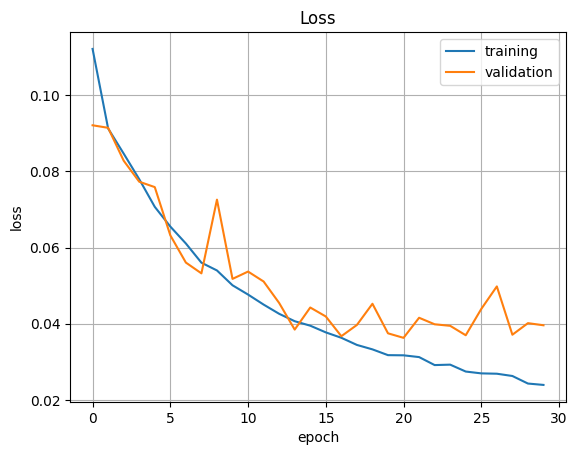

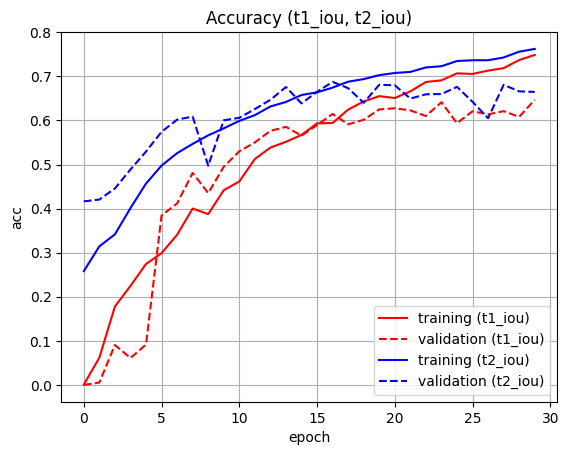

In [6]:
# curves
print(model.history)

import matplotlib.pyplot as plt
def visualize_loss(session):
    plt.figure()
    plt.plot(session.history["loss"])
    plt.plot(session.history["val_loss"])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend(["training", "validation"])
    plt.title('Loss')
visualize_loss(model.history)

def visualize_iou(session):
    plt.figure()
    plt.plot(session.history["t1_iou"], color='red')
    plt.plot(session.history["val_t1_iou"], linestyle = "--", color='red') # linewidth = 0.2,
    plt.plot(session.history["t2_iou"], color='blue')
    plt.plot(session.history["val_t2_iou"], linestyle = "--", color='blue')
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.grid()
    plt.legend(["training (t1_iou)", "validation (t1_iou)", "training (t2_iou)", "validation (t2_iou)"])
    plt.title('Accuracy (t1_iou, t2_iou)')
visualize_iou(model.history)

## [Step 2 Additional] Evaluate on testing data (U-Net (Trainable Up-Conv) Record)

In [7]:
test = dataset(["Test", ""], "./segmentation_project/test/").batch(4).prefetch(1)
model.evaluate(test)

32/32 [==============================] - 3s 79ms/step - loss: 0.0466 - t1_iou: 0.5573 - t2_iou: 0.6250


[0.046594783663749695, 0.5573108792304993, 0.6250245571136475]

## [Step 2 Additional] Display model blocks (U-Net (Trainable Up-Conv) Record)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 2)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 240, 240, 2)          0         ['input_1[0][0]']             
                                                                                                  
 1_0 (Conv2D)                (None, 240, 240, 64)         1216      ['lambda[0][0]']              
                                                                                                  
 1_1 (Conv2D)                (None, 240, 240, 64)         36928     ['1_0[0][0]']                 
                                                                                              

## Save/Load Model

In [29]:
# Model Saving
model.save('/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/segmentation_project/UNet_model.keras')

In [7]:
# Model Load
model = tf.keras.models.load_model('/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/segmentation_project/UNet_model.h5')